##### Copyright 2020 The TensorFlow IO Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Audio Data Preparation and Augmentation

## Overview

One of the biggest challanges in Automatic Speech Recognition is the preparation and augmentation of audio data. Audio data analysis could be in time or frequency domain, which adds additional complex compared with other data sources such as images.

***As a part of the TensorFlow ecosystem, `tensorflow-io` package provides quite a few useful audio-related APIs that helps easing the preparation and augmentation of audio data.***

## Setup

### Install required Packages, and restart runtime. When you restart, you don't need to execute this cell again

If you are working on a local machine, you don't need the "!" before pip.

On Google Colab, there is a problem installing tensorflow-io. The fix to this is to uninstall tensorflow and install it again.

In [ ]:
!pip uninstall tensorflow
!pip uninstall tensorflow-io
!pip install tensorflow-gpu
!pip install --no-deps tensorflow-io

Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220719082949.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Found existing installation: tensorflow-io 0.26.0
Uninstalling tensorflow-io-0.26.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/tensorflow_io-0.26.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow_io/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-io-0.26.0
Looking in indexes: https://pypi.org/simple,

/bin/bash: ip: command not found


## Usage

### Read an Audio File

In TensorFlow IO, class `tfio.audio.AudioIOTensor` allows you to read an audio file into a lazy-loaded `IOTensor`:

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

In [ ]:
len(audio)

28979

In [ ]:
audio.shape

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([28979,     1])>

In the above example, the Flac file `brooklyn.flac` is from a publicly accessible audio clip in [google cloud](https://cloud.google.com/speech-to-text/docs/quickstart-gcloud).

`AudioIOTensor` is lazy-loaded so only shape, dtype, and sample rate are shown initially. The shape of the `AudioIOTensor` is represented as `[samples, channels]`, which means the audio clip you loaded is mono channel with `28979` samples in `int16`.

The content of the audio clip will only be read as needed, either by converting `AudioIOTensor` to `Tensor` through `to_tensor()`, or though slicing. Slicing is especially useful when only a small portion of a large audio clip is needed:

In [ ]:
# Get the first 100 amplitude values
audio_slice = audio[100:]

# remove last dimension as the shape is [28979,1] we don't need the "1"
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([16 39 66 ... 56 81 83], shape=(28879,), dtype=int16)


The audio can be played through:

In [ ]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

In [ ]:
import numpy as np
np.max(audio_tensor.numpy())

16547

It is more convinient to convert tensor into float numbers and show the audio clip in graph:

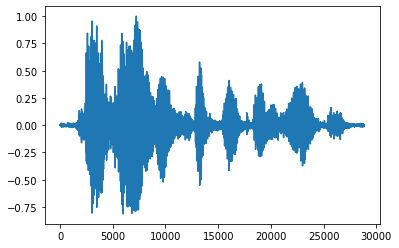

In [ ]:
import matplotlib.pyplot as plt

tensor = tf.cast(audio_tensor, tf.float32) / 16547

plt.figure()
plt.plot(tensor.numpy())

### Trim the noise

Sometimes it makes sense to trim the noise from the audio, which could be done through API `tfio.audio.trim`. Returned from the API is a pair of `[start, stop]` position of the segement:

tf.Tensor([ 1829 26668], shape=(2,), dtype=int64)
tf.Tensor(1829, shape=(), dtype=int64) tf.Tensor(26668, shape=(), dtype=int64)


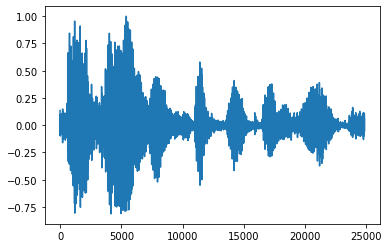

In [ ]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

### Fade In and Fade Out

One useful audio engineering technique is fade, which gradually increases or decreases audio signals. This can be done through `tfio.audio.fade`. `tfio.audio.fade` supports different shapes of fades such as `linear`, `logarithmic`, or `exponential`:

* Length of fade in.
* Length of fade out.

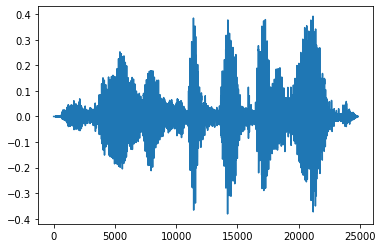

In [ ]:
fade = tfio.audio.fade(
    processed, fade_in=15000, fade_out=2000, mode="exponential")

plt.figure()
plt.plot(fade.numpy())

In [ ]:
from IPython.display import Audio

Audio(fade.numpy(), rate=audio.rate.numpy())

### Spectrogram

Advanced audio processing often works on frequency changes over time. In `tensorflow-io` a waveform can be converted to spectrogram through `tfio.audio.spectrogram`:

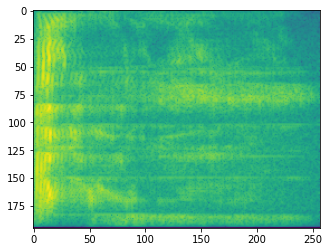

In [ ]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=128)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

Additional transformation to different scales are also possible:

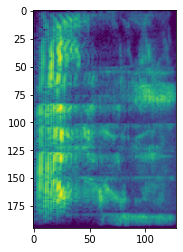

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

### SpecAugment

In addition to the above mentioned data preparation and augmentation APIs, `tensorflow-io` package also provides advanced spectrogram augmentations, most notably Frequency and Time Masking discussed in [SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition (Park et al., 2019)](https://arxiv.org/pdf/1904.08779.pdf).

#### Frequency Masking

In frequency masking, frequency channels `[f0, f0 + f)` are masked where `f` is chosen from a uniform distribution from `0` to the frequency mask parameter `F`, and `f0` is chosen from `(0, ν − f)` where `ν` is the number of frequency channels.

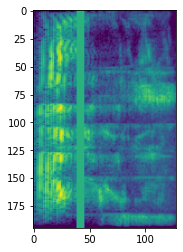

In [ ]:
# Freq masking
# Param essentially is used to saw what's the maximum "width" allowed
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(freq_mask.numpy())

#### Time Masking

In time masking, `t` consecutive time steps `[t0, t0 + t)` are masked where `t` is chosen from a uniform distribution from `0` to the time mask parameter `T`, and `t0` is chosen from `[0, τ − t)` where `τ` is the time steps.

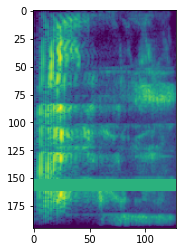

In [ ]:
# Time masking
time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=20)

plt.figure()
plt.imshow(time_mask.numpy())

<hr>

## Task 1: Implement both time and frequency masking on a single spectrogram

* Use ``dbscale_mel_spectrogram`` as the original input
* Plot the resulting spectrogram

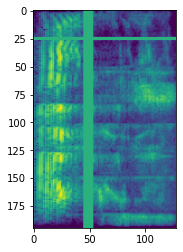

In [ ]:
freq_mask2 = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)
time_mask2 = tfio.audio.time_mask(freq_mask2, param=20)

plt.figure()
plt.imshow(time_mask2.numpy())

## Task 2: Implement both time and frequency masking one a single spectrogram by writing a new function which accepts one input along with two parameters, one for time masking and the other for frequency masking

* Get inspiration from the original code on Tensorflow's github page. See below. Adapt these two functions into a single one.
  1. time masking is detailed here: https://github.com/tensorflow/io/blob/v0.24.0/tensorflow_io/python/ops/audio_ops.py#L344
  2. frequency masking is detailed here: https://github.com/tensorflow/io/blob/v0.24.0/tensorflow_io/python/ops/audio_ops.py#L319
* Call the function ``time_and_frequency_mask``.
* The function should take 3 inputs, namely, ``input``, ``param_time``, ``param_freq``.
* Then use ``dbscale_mel_spectrogram`` variable which was generated above to test that your new function works.
* The function signature will look like this ``def time_and_frequency_mask(input, param_time, param_freq):``

In [ ]:
def time_and_frequency_mask(input, param_time, param_freq):

    input = tf.convert_to_tensor(input)
    
    freq_max = tf.shape(input)[1]
    f = tf.random.uniform(shape=(), minval=0, maxval=param_freq, dtype=tf.dtypes.int32)
    f0 = tf.random.uniform(
        shape=(), minval=0, maxval=freq_max - f, dtype=tf.dtypes.int32
    )
    indices = tf.reshape(tf.range(freq_max), (1, -1))
    condition = tf.math.logical_and(
        tf.math.greater_equal(indices, f0), tf.math.less(indices, f0 + f)
    )

    freq_masked = tf.where(condition, tf.cast(0, input.dtype), input)

    time_max = tf.shape(freq_masked)[0]
    t = tf.random.uniform(shape=(), minval=0, maxval=param_time, dtype=tf.dtypes.int32)
    t0 = tf.random.uniform(
        shape=(), minval=0, maxval=time_max - t, dtype=tf.dtypes.int32
    )
    indices = tf.reshape(tf.range(time_max), (-1, 1))
    condition = tf.math.logical_and(
        tf.math.greater_equal(indices, t0), tf.math.less(indices, t0 + t)
    )
    return tf.where(condition, tf.cast(0, input.dtype), freq_masked)

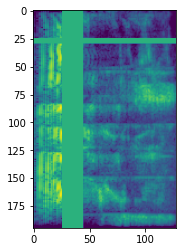

In [ ]:
mask = time_and_frequency_mask(dbscale_mel_spectrogram, 20, 30)

plt.figure()
plt.imshow(mask.numpy())

## Task 3: Implement a blending function which performs a linear combination of two inputs using two weights. 

* Call the function ``blend``.
* The function should take 4 inputs, namely, ``input1``, ``input2``, ``w1``, ``w2``.
* Weights are real valued numbered between $[0, 1]$ such that $w_1 + w_2 = 1$.
* Thus, your function should perform this operation: $w_1 \times input_1 + w_2 \times input_2$.
* Then use ``freq_mask`` and ``time_mask`` variables which were generated above to test that your new function works.
* Vary the weights to make sure your function works.
* The function signature will look like this: ``def blend(input1, input2, w1, w2):``

In [ ]:
def blend(input1, input2, w1, w2):

  input1 = tf.convert_to_tensor(input1)
  input2 = tf.convert_to_tensor(input2)

  weighted_1 = tf.math.multiply(input1, w1)
  weighted_2 = tf.math.multiply(input2, w2)
  result = weighted_1 + weighted_2

  return result

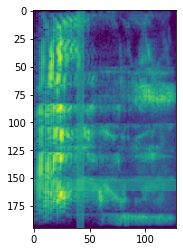

In [ ]:
mask = blend(freq_mask, time_mask, 0.5, 0.5)

plt.figure()
plt.imshow(mask.numpy())